# Freshet Predictor for Rainy Lake

Freshet refers to the spring thaw evidenced by snow and ice melt in streams and rivers. The purose of these notes is explore the possibililty of predicting freshet for Rainy Lake and Rainy River from temperature and real-time measurements.

## Initialization

### Load Python Modules

In [2]:
# Display graphics inline with the notebook
%matplotlib inline

# Standard Python modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime

# Module to enhance matplotlib plotting
import seaborn
seaborn.set()

# Modules to display images and data tables
from IPython.display import Image
from IPython.core.display import display

# Styles
from IPython.core.display import HTML
HTML(open("styles/custom.css", "r").read())

## Rainy Lake Inflow Data Series

Date
1948-01-01    222.529
1948-01-02    286.000
1948-01-03    258.470
1948-01-04    237.707
1948-01-05    279.853
Name: Stn Value, dtype: float64

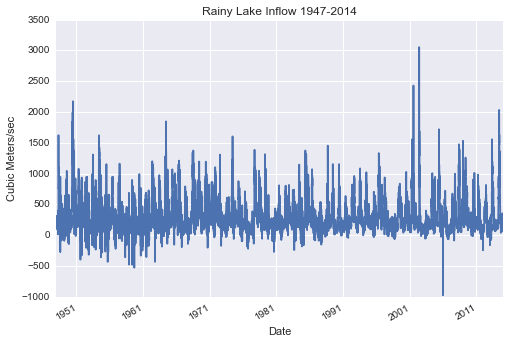

In [3]:
# Read .csv file
RL_INFLOW = pd.read_csv('./data/RainyLakeInflows.csv',
                      index_col=0,parse_dates=True,skiprows=3)
RL_INFLOW = pd.Series(RL_INFLOW['Stn Value'],index=RL_INFLOW.index)
RL_INFLOW = RL_INFLOW["1948":"2014"]

display(RL_INFLOW.head())

RL_INFLOW.plot()
plt.title('Rainy Lake Inflow 1947-2014')
plt.ylabel('Cubic Meters/sec')
plt.xlabel('Date')

### Total Annual Inflows by Year

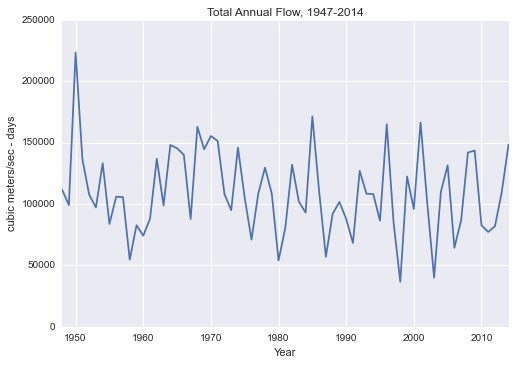

In [4]:
RL_INFLOW.groupby(RL_INFLOW.index.year).sum().plot()


plt.title('Total Annual Flow, 1947-2014')
plt.ylabel('cubic meters/sec - days')
plt.xlabel('Year')

### Inflows by Day of Year

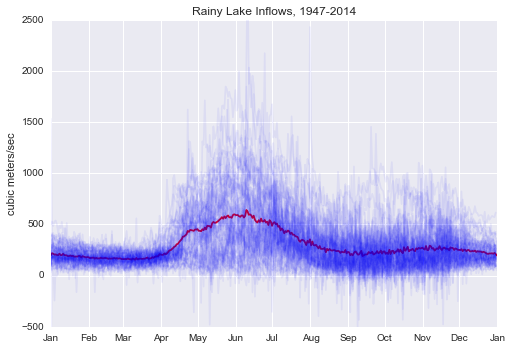

In [5]:
plt.hold(True)
RL_INFLOW.groupby(RL_INFLOW.index.dayofyear).mean().plot(color='r')

for (yr,r) in RL_INFLOW.groupby(RL_INFLOW.index.year):
    plt.plot(r.index.dayofyear,r.values,'b',alpha=0.06)

plt.hold(False)


plt.title('Rainy Lake Inflows, 1947-2014')
plt.ylabel('cubic meters/sec')

plt.xlim([1,366])
plt.ylim([-500,2500])
mo = np.cumsum([1,31,28.25,31,30,31,30,31,31,30,31,30,31])
lbl = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan']
plt.xticks(mo,lbl);

## Ice Out Data Series

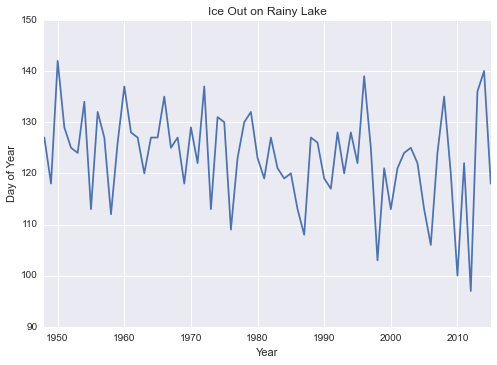

In [6]:
# Read .csv file
RL_ICEOUT = pd.read_csv('./data/IceOut_RL.txt',index_col=0,parse_dates=True,skiprows=1)

# Remove duplicated data
RL_ICEOUT = RL_ICEOUT[RL_ICEOUT[' source']=='MNDNR-SCO']

# Drop unneeded columns
RL_ICEOUT.drop(' source',1,inplace=True)
RL_ICEOUT.drop(' comments',1,inplace=True)

# Slice to 1948 and forward
RL_ICEOUT = RL_ICEOUT['1948':]

# Create 'day of year' ice out events
RL_ICEOUT = pd.Series(RL_ICEOUT.index.dayofyear, index=RL_ICEOUT.index.year)

# Display
RL_ICEOUT.plot()
plt.title('Ice Out on Rainy Lake')
plt.ylabel('Day of Year')
plt.xlabel('Year')

## KINL Temperature Series

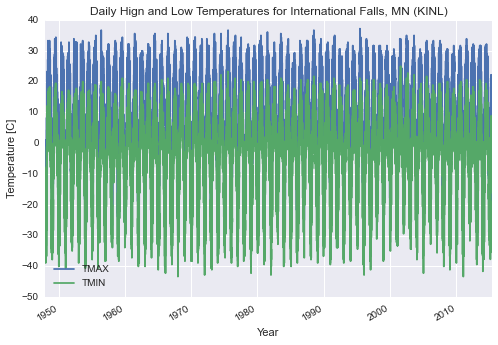

In [7]:
TEMP = pd.read_csv('./data/528052.csv',index_col=2,parse_dates=True);

# Drop unneeded columns
TEMP.drop('STATION',axis=1,inplace=True)
TEMP.drop('STATION_NAME',axis=1,inplace=True)
TEMP.drop('TOBS',axis=1,inplace=True)

# Substitute NaN for missing data
TEMP.ix[TEMP['TMAX']==-9999,'TMAX'] = float('nan')
TEMP.ix[TEMP['TMIN']==-9999,'TMIN'] = float('nan')

# Convert to Celcius
TEMP = TEMP/10.0

# Slice to 1948 and forward
TEMP = TEMP['1948':]

# Display
TEMP['TMAX'].plot()
plt.hold(True)
TEMP['TMIN'].plot()
plt.hold(False)
plt.legend(loc='best')

plt.title('Daily Hign and Low Temperatures for International Falls, MN (KINL)')
plt.ylabel('Temperature [C]')
plt.xlabel('Year')

In [8]:
# Create some additional regressors

fpos = lambda x: max(0,x)
fneg = lambda x: min(0,x)

TEMP['TMAXpos'] = TEMP['TMAX'].apply(fpos)
TEMP['TMAXneg'] = TEMP['TMAX'].apply(fneg)
TEMP['TMINpos'] = TEMP['TMIN'].apply(fpos)
TEMP['TMINneg'] = TEMP['TMIN'].apply(fneg)

display(TEMP.head())
display(TEMP.tail())

,TMAX,TMIN,TMAXpos,TMAXneg,TMINpos,TMINneg
DATE,,,,,,
1948-01-01,-8.9,-30.0,0,-8.9,0,-30.0
1948-01-02,-5.6,-12.2,0,-5.6,0,-12.2
1948-01-03,-5.0,-10.6,0,-5.0,0,-10.6
1948-01-04,-4.4,-8.3,0,-4.4,0,-8.3
1948-01-05,-0.6,-10.0,0,-0.6,0,-10.0


,TMAX,TMIN,TMAXpos,TMAXneg,TMINpos,TMINneg
DATE,,,,,,
2015-04-25,13.3,1.1,13.3,0,1.1,0.0
2015-04-26,15.6,-4.9,15.6,0,0.0,-4.9
2015-04-27,20.0,-4.9,20.0,0,0.0,-4.9
2015-04-28,15.6,-2.1,15.6,0,0.0,-2.1
2015-05-01,21.1,2.2,21.1,0,2.2,0.0


## Identifying the Freshet

## An 'Ice-Out' Index

This section fits the cumulative temperature regressors to an 'ice-out' index. An index value of 1000 to corresponds to ice-out.

In [19]:
cols = ['TMAXpos','TMAXneg','TMINpos','TMINneg']

X = pd.DataFrame(index=RL_ICEOUT.index)

for (yr,r) in TEMP.groupby(TEMP.index.year):
    for c in cols:
        temp = r[c].cumsum()
        X.ix[yr,c] = temp[RL_ICEOUT[yr]]
    #X.ix[yr,'DOY'] = float(RL_ICEOUT[yr]**2)

Y = pd.Series(1000.0, index=RL_ICEOUT.index)
        
model = pd.ols(y=Y,x=X,intercept=False)
print model


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <TMAXpos> + <TMAXneg> + <TMINpos> + <TMINneg>

Number of Observations:         68
Number of Degrees of Freedom:   4

R-squared:         0.9910
Adj R-squared:     0.9905

Rmse:             97.5944

F-stat (4, 64):  1768.8409, p-value:     0.0000

Degrees of Freedom: model 4, resid 64

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
       TMAXpos     1.1219     0.1334       8.41     0.0000     0.8604     1.3834
       TMAXneg     0.5974     0.1439       4.15     0.0001     0.3154     0.8794
       TMINpos    -1.7505     0.6726      -2.60     0.0115    -3.0687    -0.4323
       TMINneg    -0.5117     0.0669      -7.64     0.0000    -0.6429    -0.3805
---------------------------------End of Summary-----

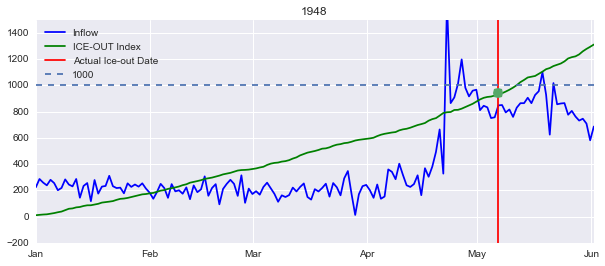

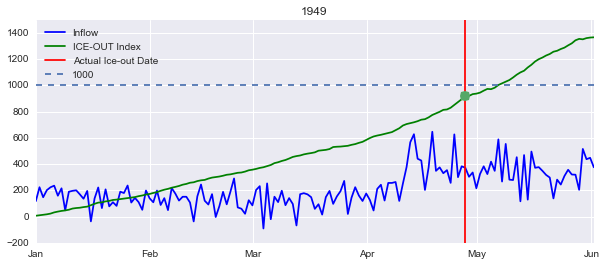

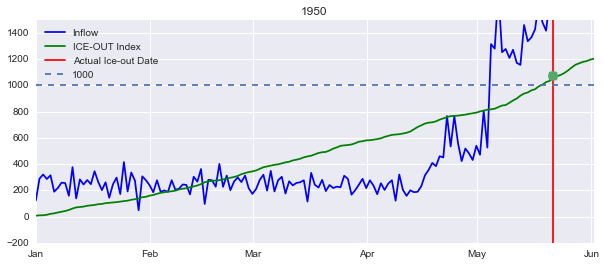

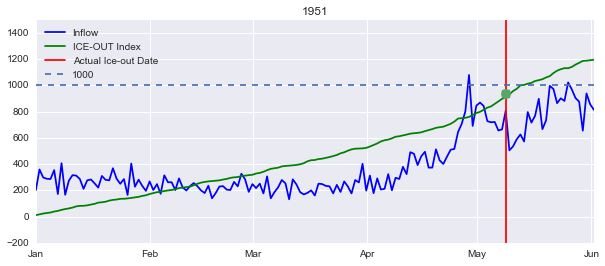

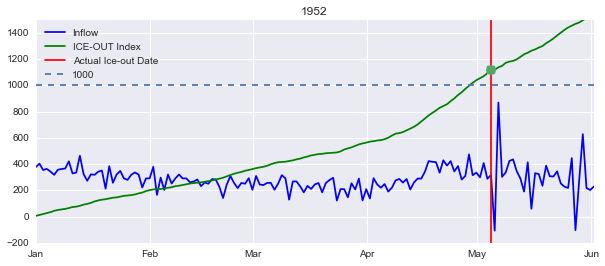

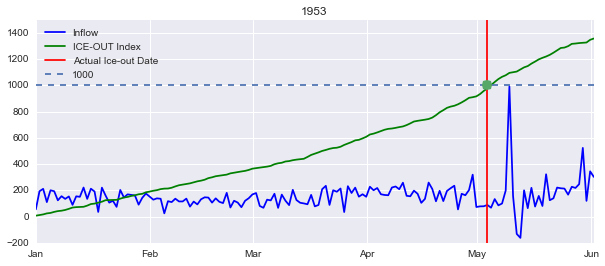

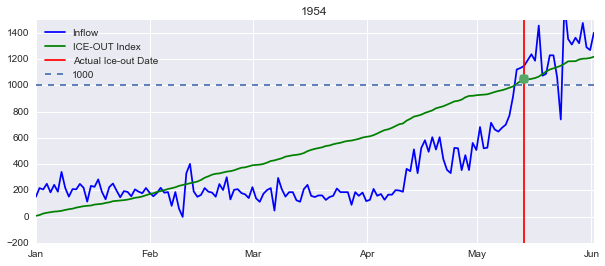

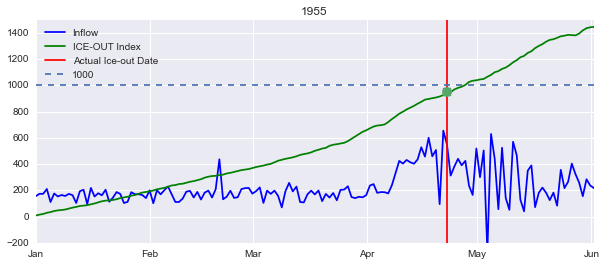

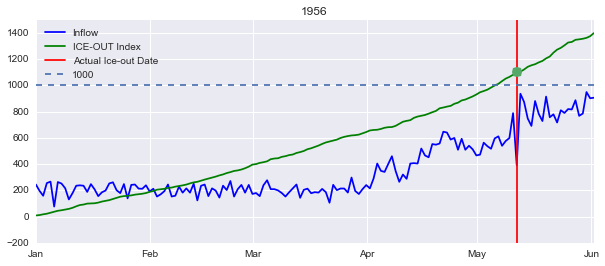

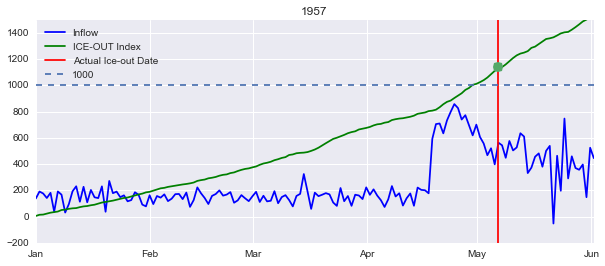

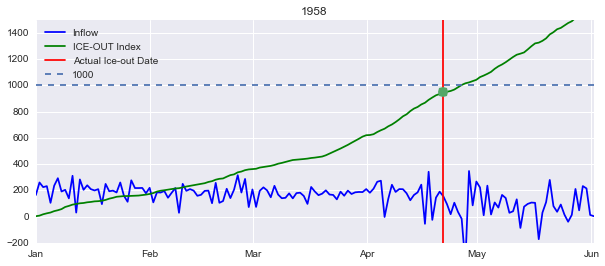

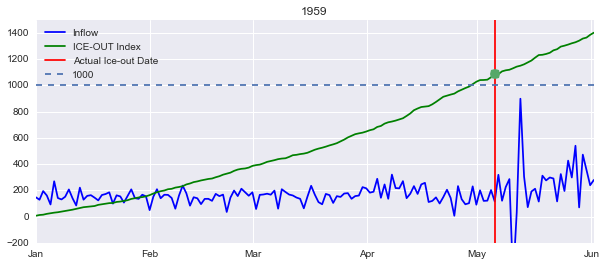

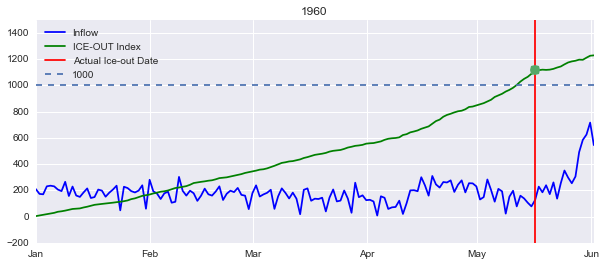

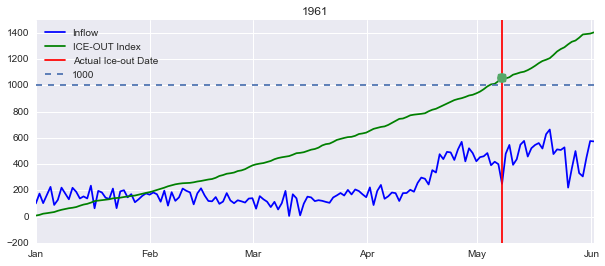

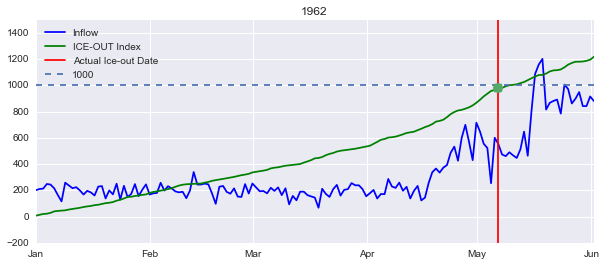

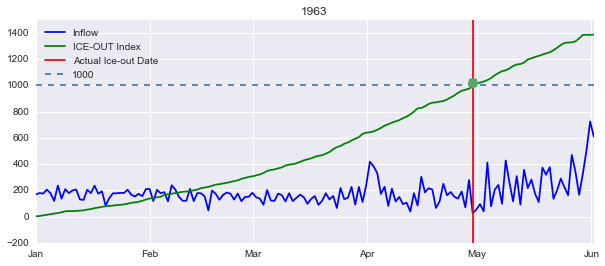

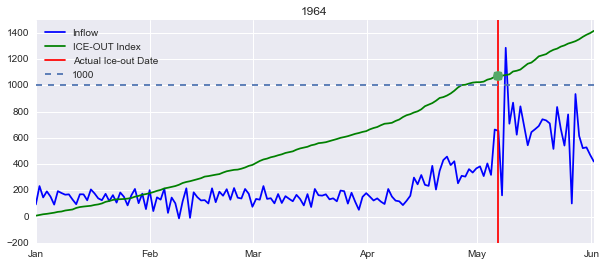

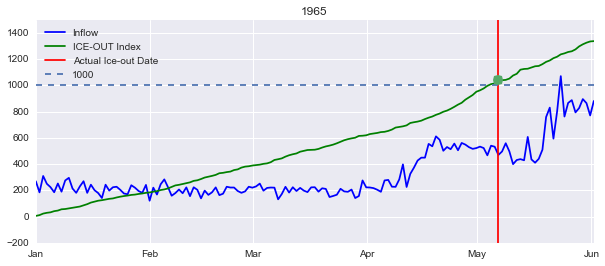

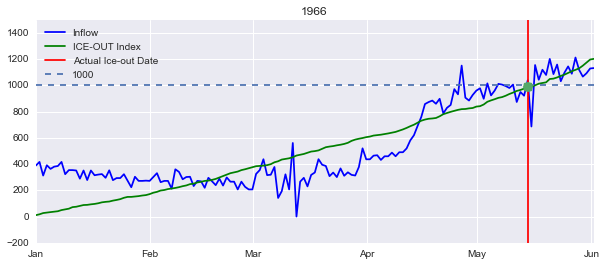

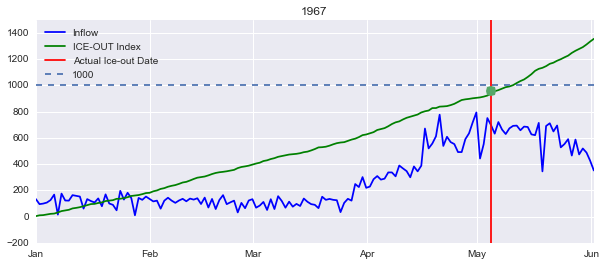

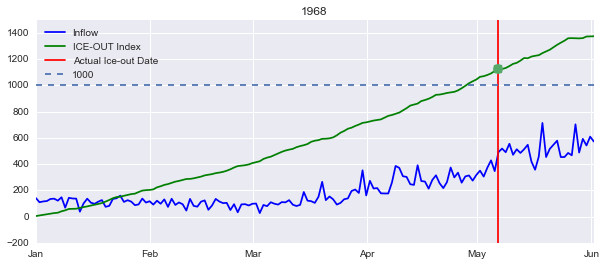

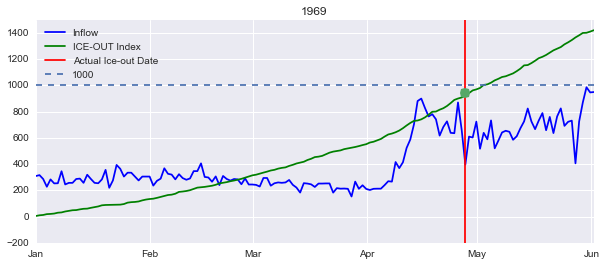

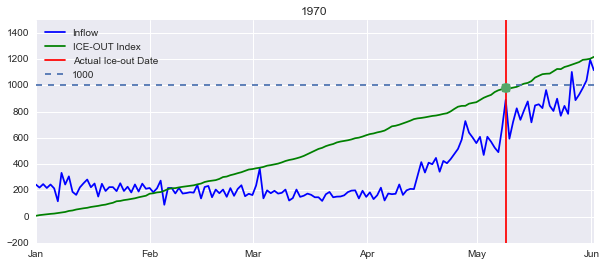

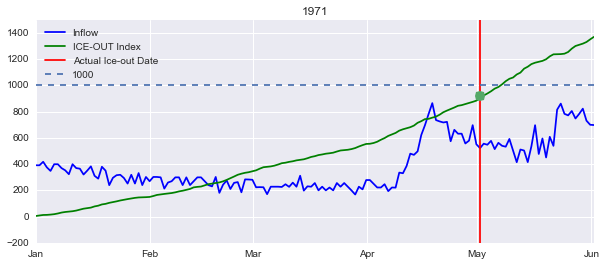

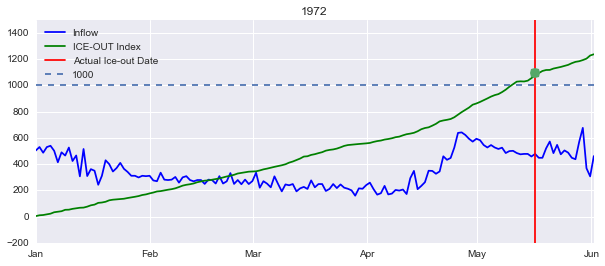

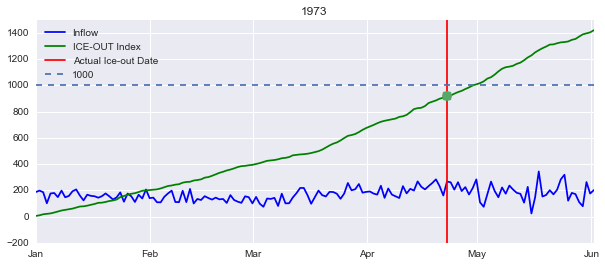

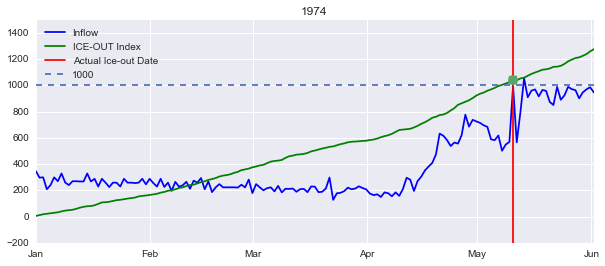

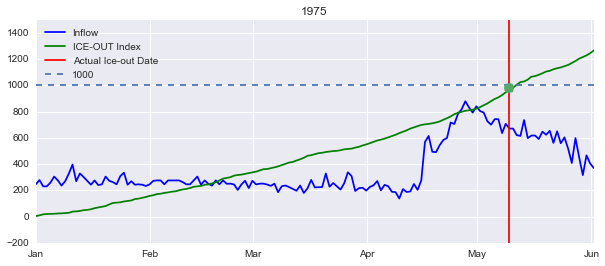

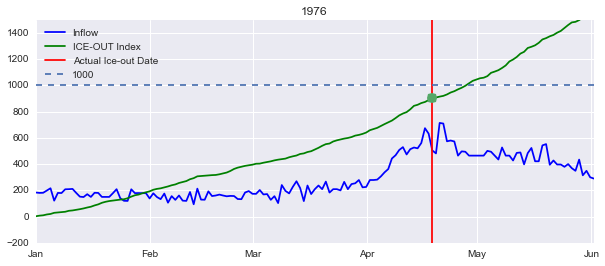

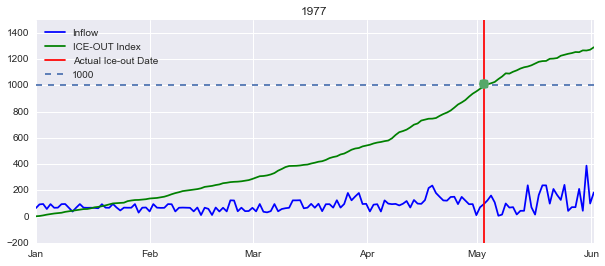

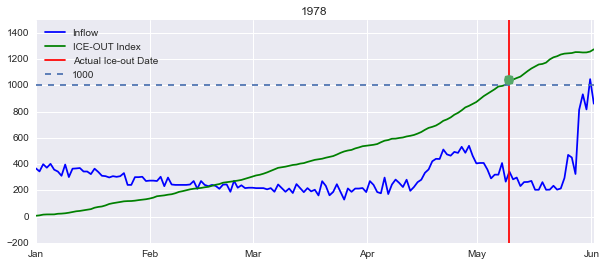

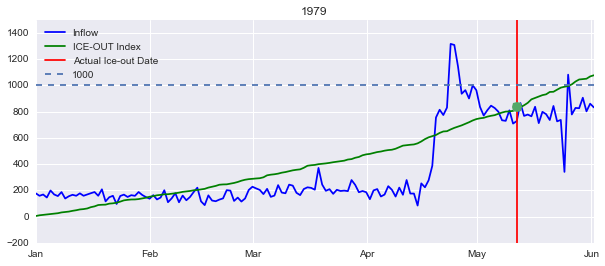

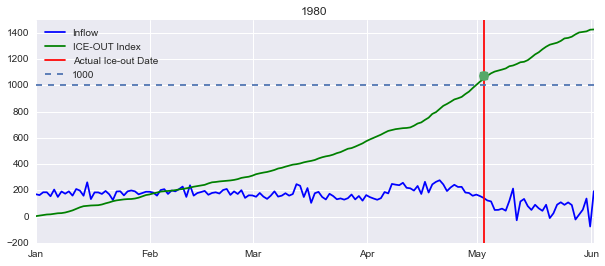

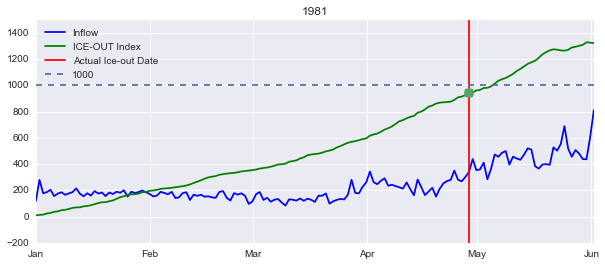

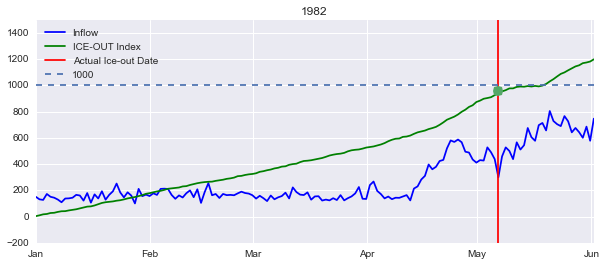

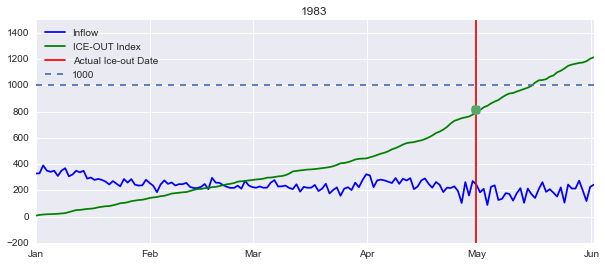

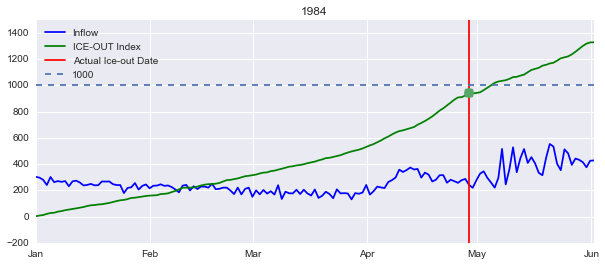

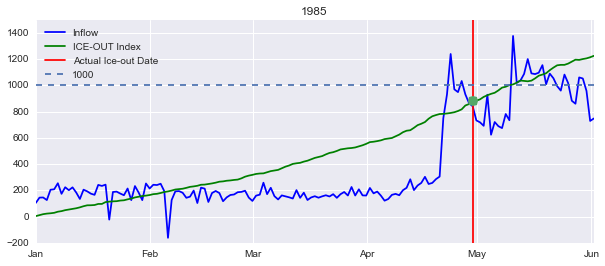

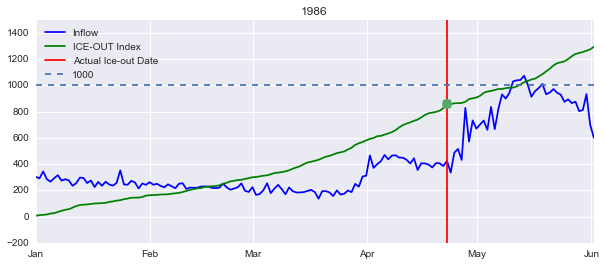

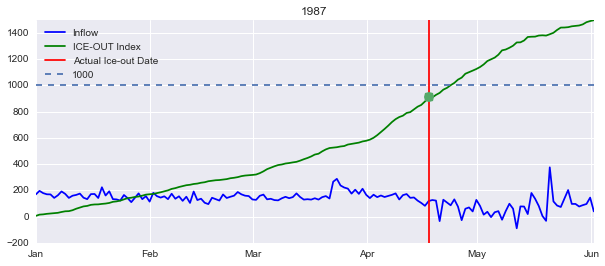

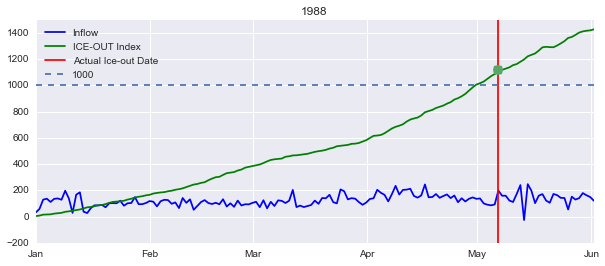

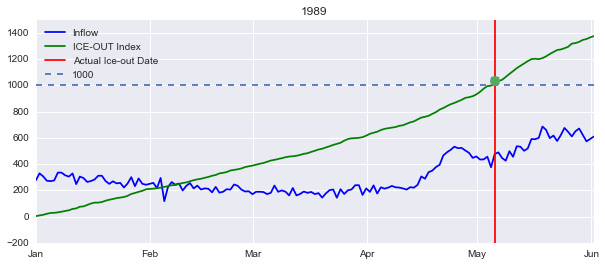

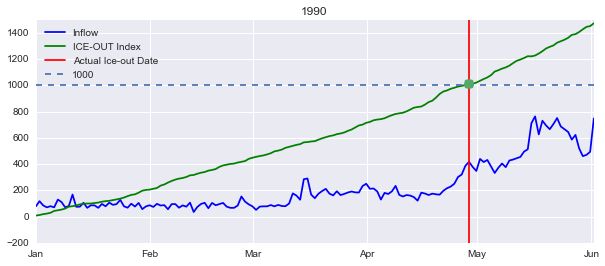

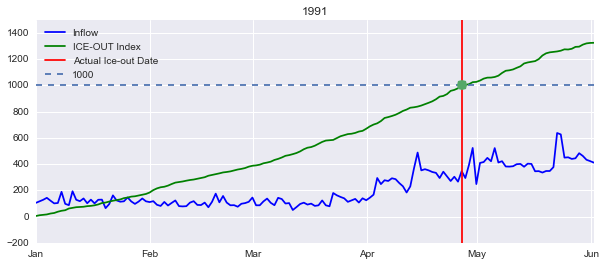

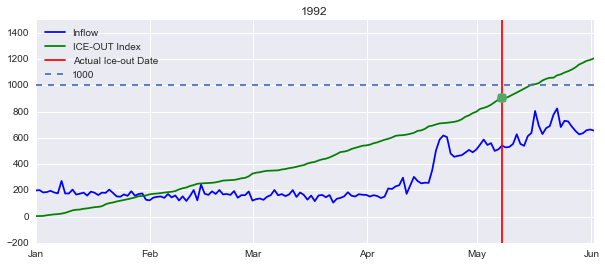

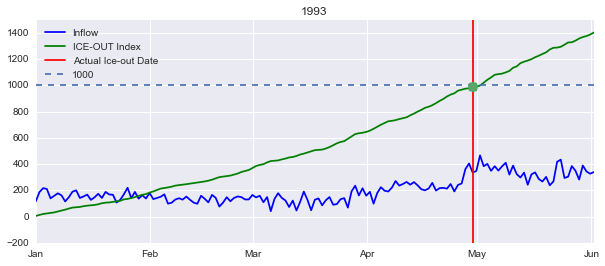

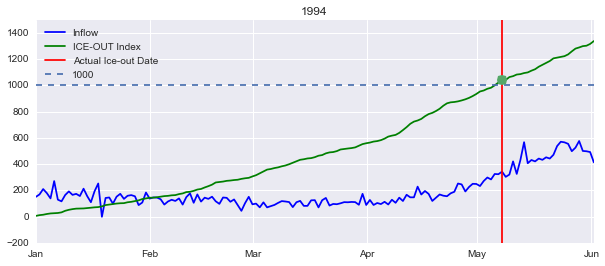

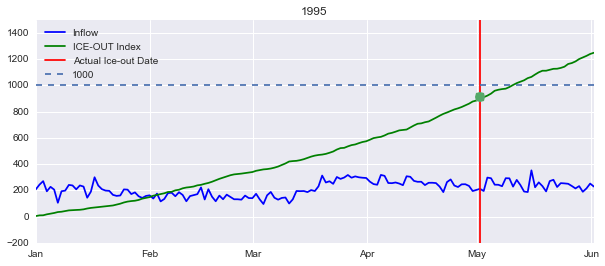

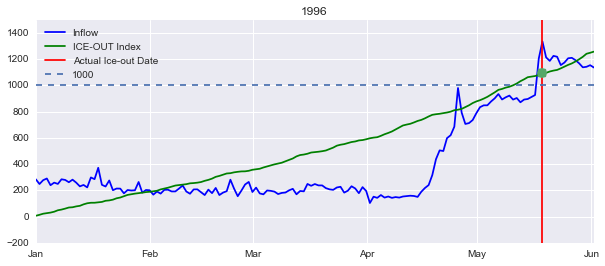

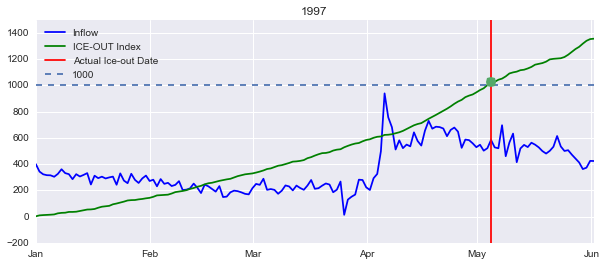

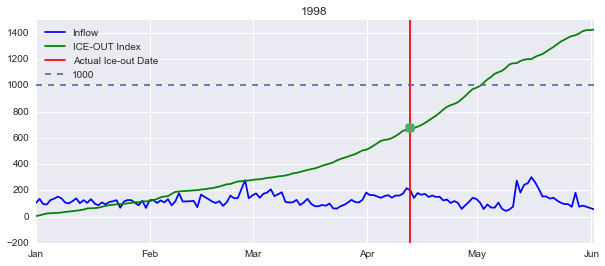

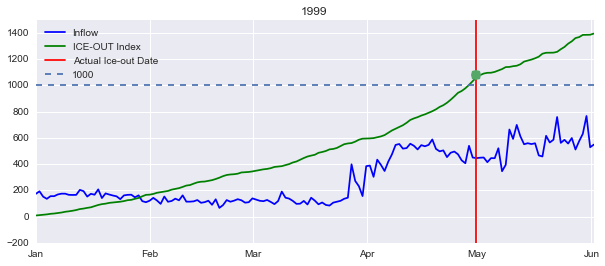

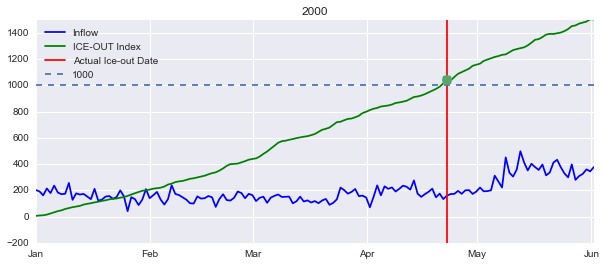

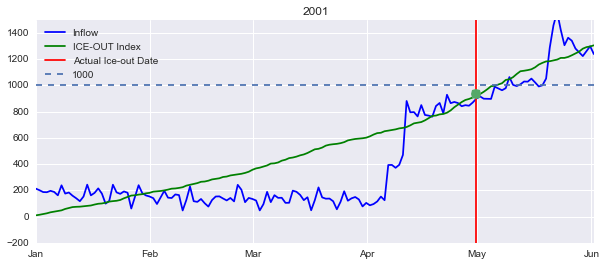

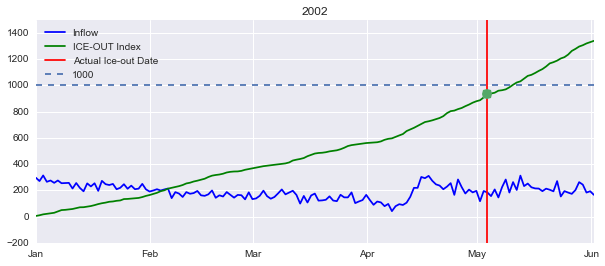

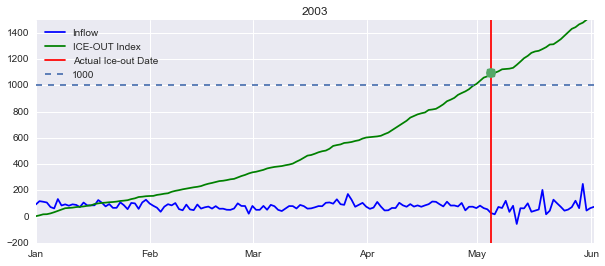

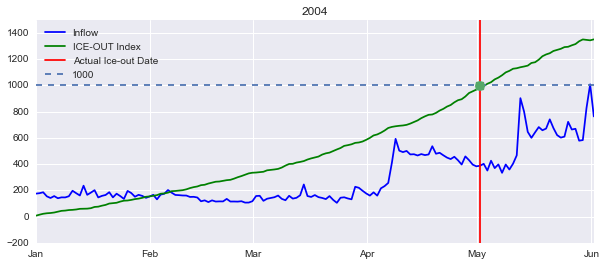

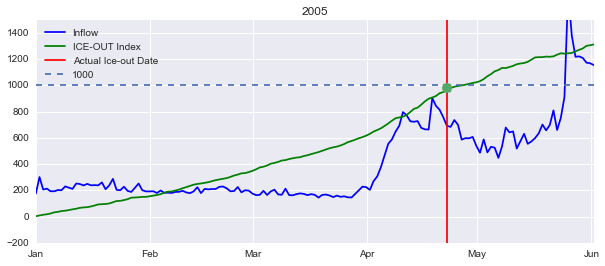

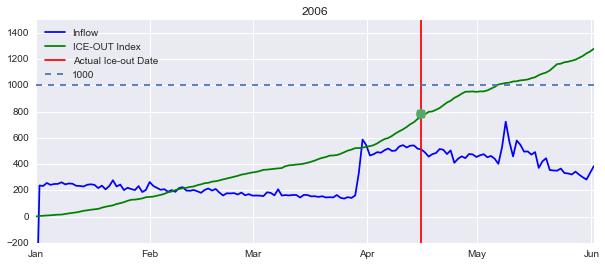

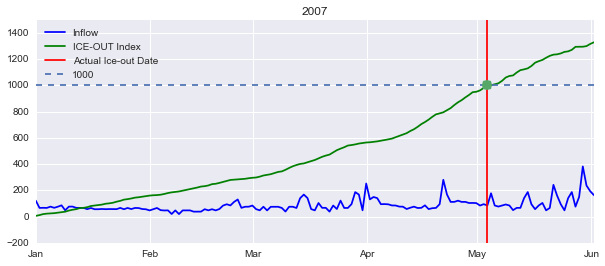

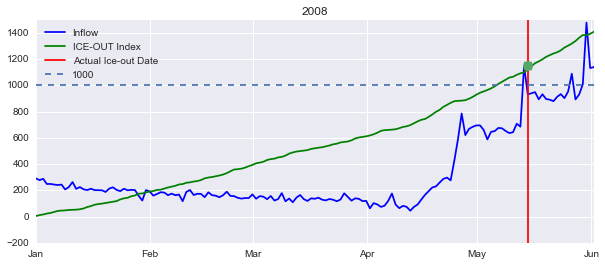

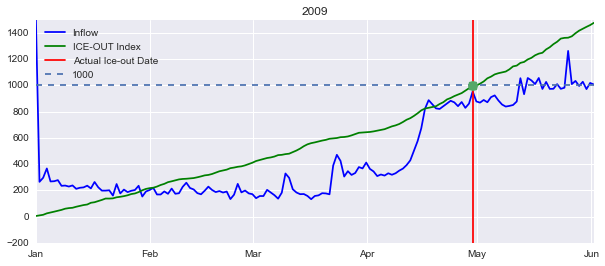

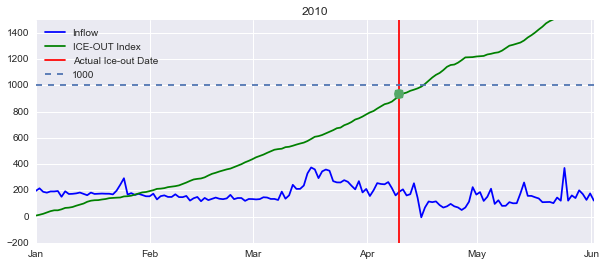

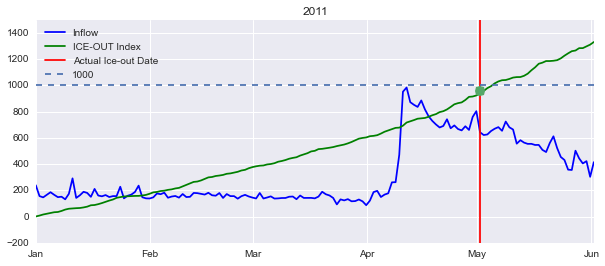

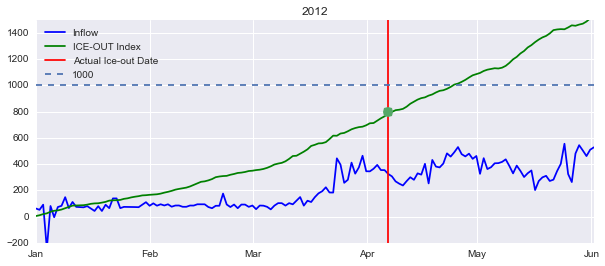

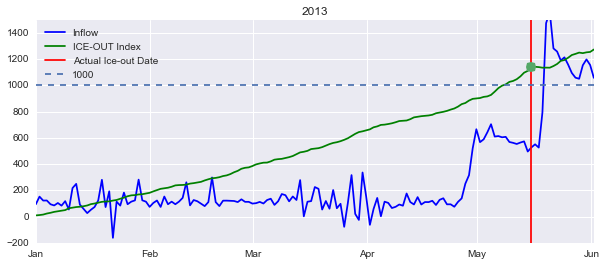

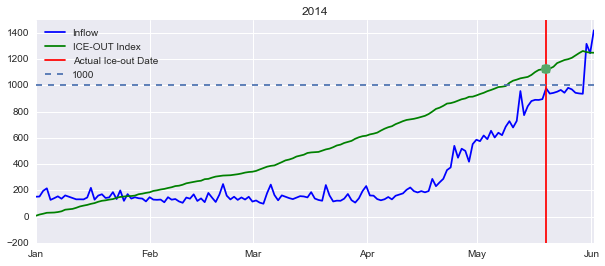

In [21]:
mo = np.cumsum([1,31,28.25,31,30,31,30,31,31,30,31,30,31])
lbl = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan']

for (yr,r) in TEMP.groupby(TEMP.index.year):
    TEMP.loc[TEMP.index.year==yr,'y'] =  \
        + model.beta['TMAXpos']*r['TMAXpos'].cumsum() \
        + model.beta['TMAXneg']*r['TMAXneg'].cumsum() \
        + model.beta['TMINpos']*r['TMINpos'].cumsum() \
        + model.beta['TMINneg']*r['TMINneg'].cumsum() \
      #  + model.beta['DOY']*float(RL_ICEOUT[yr]**2)
        
for (yr,r) in RL_INFLOW.groupby(RL_INFLOW.index.year):
    r = r[r.index.dayofyear <= 153]
    plt.figure(figsize=(10,4))
    plt.plot(r.index.dayofyear,r.values,'b')
    plt.hold(True)
    t = TEMP[TEMP.index.year==yr]['y']
    t = t[t.index.dayofyear <= 153]
    plt.plot(t.index.dayofyear,t,'g')
    plt.plot([RL_ICEOUT[yr],RL_ICEOUT[yr]],[-200,1500],'r')
    plt.plot([1,153],[1000,1000],'--')
    plt.plot(RL_ICEOUT[yr],t[RL_ICEOUT[yr]],'.',ms=20)
    plt.hold(False)
    plt.legend(['Inflow','ICE-OUT Index','Actual Ice-out Date','1000'],loc='upper left')
    plt.title("{0:d}".format(yr))
    plt.xticks(mo,lbl);
    plt.xlim([1,153])
    plt.ylim([-200,1500])

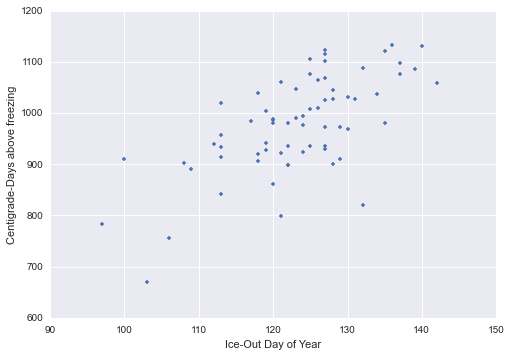

In [12]:
Z = np.array([[float(RL_ICEOUT[yr]),float(r[r.index.dayofyear==RL_ICEOUT[yr]]['y'])] for \
    (yr,r) in TEMP.groupby(TEMP.index.year)])
Z = Z.T

plt.plot(Z[0],Z[1],'.')

plt.ylabel('Centigrade-Days above freezing')
plt.xlabel('Ice-Out Day of Year')
